# Train the UNet model to Segment Fashion picture

## UNet Model
- UNet is a type of convolutional neural network (CNN) designed primarily for biomedical image segmentation but has found applications in various image segmentation tasks, including fashion item segmentation. Here's how it works: <br>

### Architecture: <br>

- Encoder: The encoder is a series of convolutional layers followed by max-pooling layers that capture the contextual information and reduce the spatial dimensions of the input image. This step is often referred to as downsampling. <br>
- Bottleneck: This is the layer between the encoder and decoder that processes the most abstract features. <br>
- Decoder: The decoder consists of upsampling layers that increase the spatial dimensions of the features, followed by convolutional layers that reconstruct the segmented image. This step is often referred to as upsampling. <br>
- Skip Connections: These connections between corresponding layers in the encoder and decoder allow the model to retain spatial information that may be lost during downsampling, leading to more precise segmentation. <br>

### Segmentation Process: <br>

- Input: The input image (containing items like clothes, bags, and shoes) is fed into the UNet model. <br>
- Output: The model outputs a segmented image where each pixel is classified as belonging to either the foreground (items) or the background. <br>

In [2]:
# Install the 'gdown' and 'rarfile' packages
!pip install gdown rarfile
# Install the 'unrar' package for extracting RAR files
!apt-get install unrar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  unrar
0 upgraded, 1 newly installed, 0 to remove and 80 not upgraded.
Need to get 113 kB of archives.
After this operation, 406 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 unrar amd64 1:5.6.6-2build1 [113 kB]
Fetched 113 kB in 0s (1560 kB/s)
Selecting previously unselected package unrar.
(Reading database ... 113807 files and directories currently installed.)
Preparing to unpack .../unrar_1%3a5.6.6-2build1_amd64.deb ...
Unpacking unrar (1:5.6.6-2build1) ...
Setting up unrar (1:5.6.6-2build1) ...
update-alternatives: using /usr/bin/unrar-nonfree to provide /usr/bin/unrar (unrar) in auto mode
update-alternatives: warning: skip creation of /usr/share/man/man1/unrar.1.gz because associated file /usr/share/man/man1/unrar-nonfree.1.gz (of link group unrar) doesn't exist
Processing triggers f

In [3]:
# Download the exmaples repository from the TensorFlow GitHub page and install the required packages
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U keras
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-s9qqh0it
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-s9qqh0it
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=1c4e8c0b05ff2fef587ca666c7e97fdea06300a0b430b97e135340c776257723
  Stored in directory: /tmp/pip-ephem-wheel-cache-udbdyqkn/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not ins

In [4]:
# import the necessary packages

import os
from glob import glob
import tensorflow as tf
import numpy as np
from PIL import Image
import gdown
import rarfile
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from  tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow_examples.models.pix2pix import pix2pix

2024-07-21 15:00:25.319155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 15:00:25.340213: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 15:00:25.346684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# Define a function to pad an image to a square shape
def pad_to_square(image):
    shape = tf.shape(image)
    height, width = shape[0], shape[1]
    max_dim = tf.maximum(height, width)

    pad_height = (max_dim - height) // 2
    pad_width = (max_dim - width) // 2

    padding = [[pad_height, max_dim - height - pad_height],
               [pad_width, max_dim - width - pad_width],
               [0, 0]]
    padded_image = tf.pad(image, padding, mode='CONSTANT', constant_values=255)
    return padded_image


# Define a function to read an image and its mask and preprocess them padding them to a square shape and resizing them to 256x256
def load_image(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)

    img = pad_to_square(img)
    mask = pad_to_square(mask)

    img = tf.image.resize(img, [256, 256])
    mask = tf.image.resize(mask, [256, 256])
    
    img = img/255.0
    mask = mask/255.0

    return img, mask


# display some sample data
def display_sample_data(dataset, num_samples=3):
    plt.figure(figsize=(10, 10))
    for images, masks in dataset.take(random.randint(1, len(dataset))):
        for i in range(num_samples):
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(images[i] )
            plt.axis('off')
            plt.subplot(2, num_samples, num_samples + i + 1)
            plt.imshow(tf.squeeze(masks[i]),cmap="gray")
            plt.axis('off')
    plt.show()

## Instructions
the masks are in should be in the same order as the pictures in the .rar file for pictures<br>
you can download the clothes dataset (pictures and annotations) from deepfashion2 dataset https://github.com/switchablenorms/DeepFashion2<br>
you can download the bags dataset (pictures and annotations) from https://universe.roboflow.com/search?q=bags%20annotated<br>
you can download the shoes dataset (pictures and annotations) from https://universe.roboflow.com/search?q=shoes+annotation<br>
you may need to convert the annotations to masks so please check annotation_conversion.ipynb for more information<br>


In [6]:
# in that file, there are more that 10000 picture in .jpg format in 3 different classes (clothes, bags, shoes)
# Define the URL of the .rar file for pictures
file_url_pictures = 'https://drive.google.com/uc?id=************************'  # add here link to the file containing the pictures

# Define the path to download the .rar file for pictures
rar_file_path_pictures = '/kaggle/working/rar_file_path_pictures.rar'

# Download the .rar file for pictures
gdown.download(file_url_pictures, rar_file_path_pictures, quiet=False)

# Define the directory where the .rar file will be extracted
extracted_dir_pictures = '/kaggle/working/pictures'
os.makedirs(extracted_dir_pictures, exist_ok=True)

# Extract the .rar file for pictures
with rarfile.RarFile(rar_file_path_pictures) as rf:
    rf.extractall(extracted_dir_pictures)




# in that file, there are more that 10000 masks in .jpg format in 3 different classes (clothes, bags, shoes)
# Define the URL of the .rar file for all the masks
file_url_mask = 'https://drive.google.com/uc?id=*********************************'   # add here link to the file containing the masks

# Define the path to download the .rar file for masks
rar_file_path_mask = '/kaggle/working/rar_file_path_mask.rar'

# Download the .rar file for masks
gdown.download(file_url_mask, rar_file_path_mask, quiet=False)

# Define the directory where the .rar file will be extracted
extracted_dir_mask = '/kaggle/working/masks'
os.makedirs(extracted_dir_mask, exist_ok=True)

# Extract the .rar file for masks
with rarfile.RarFile(rar_file_path_mask) as rf:
    rf.extractall(extracted_dir_mask)


#usage
img_paths = glob(os.path.join(extracted_dir_pictures, '*.jpg'))
mask_paths = glob(os.path.join(extracted_dir_mask, '*.jpg'))


Downloading...
From (original): https://drive.google.com/uc?id=1R7WxqwXRq5m4QC83tgMmYbWtjcA2VzJw
From (redirected): https://drive.google.com/uc?id=1R7WxqwXRq5m4QC83tgMmYbWtjcA2VzJw&confirm=t&uuid=0cc945af-e772-464a-8259-c3ade62966c2
To: /kaggle/working/rar_file_path_pictures.rar
100%|██████████| 523M/523M [00:04<00:00, 112MB/s]  
Downloading...
From (original): https://drive.google.com/uc?id=1kZ0qMgM8sf2DKiSJhrK7ql2pTLM5k1Ym
From (redirected): https://drive.google.com/uc?id=1kZ0qMgM8sf2DKiSJhrK7ql2pTLM5k1Ym&confirm=t&uuid=3ed9a891-b650-443f-bcc1-fb3436b2e750
To: /kaggle/working/rar_file_path_mask.rar
100%|██████████| 71.6M/71.6M [00:00<00:00, 108MB/s] 


In [9]:

# sort the paths to make sure that the images and masks are in the same order
img_paths.sort()
mask_paths.sort()

# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
dataset = dataset.map(lambda img, mask: load_image(img, mask), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# shuffle the dataset
dataset = dataset.shuffle(buffer_size=len(img_paths))

# split the dataset into trian and test 
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# print the shape of the batch for the mask and the images 
for images, masks in dataset.take(1):
    print(images.shape, masks.shape)


(32, 256, 256, 3) (32, 256, 256, 1)


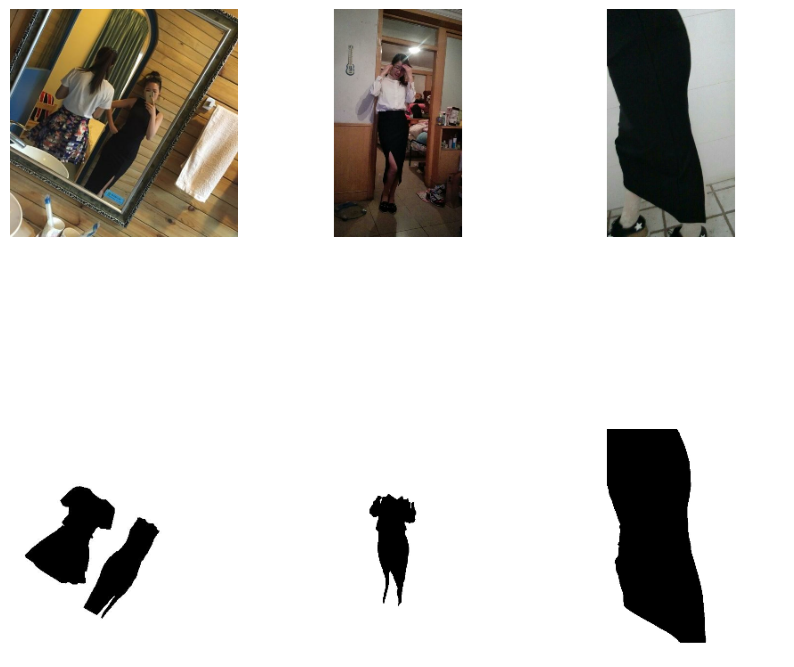

In [12]:

# display some sample data form dataset 
display_sample_data(dataset)

## Create the U-Net model 
- The U-Net model is used to segment the images and extract the clothes,bags or shoes from the images.<br>
- The encoder part of the U-Net model is a pretrained MobileNetV2 model (without the top layer) we will use the encoder to extract the features from the images after traing it on (clothes, bags, shoes) dataset.<br>
- The decoder part of the U-Net model is a series of Conv2DTranspose layers that will upsample the features extracted by the encoder to the original image size.<br> 

In [9]:

# Load MobileNetV2 as the base model
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Define the layers to use for feature extraction
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

# Get the output of the layers
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model (encoder)
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

# Define the upsampling blocks for the decoder
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

# Define the U-Net model
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # Final convolutional layer for segmentation
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)



# Define the number of output classes
OUTPUT_CLASSES = 2  # Binary segmentation (foreground/background)

# Instantiate the model
model = unet_model(output_channels=OUTPUT_CLASSES)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define the number of epochs
EPOCHS = 20

# Train the model
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          validation_data=test_dataset,
                          verbose=2 )


/tmp/ipykernel_34/2610916452.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.

  base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Epoch 1/20



I0000 00:00:1720568938.536967  296608 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


268/268 - 112s - 419ms/step - accuracy: 0.8731 - loss: 0.2545 - val_accuracy: 0.8880 - val_loss: 0.2482

Epoch 2/20

268/268 - 100s - 375ms/step - accuracy: 0.8908 - loss: 0.2126 - val_accuracy: 0.9054 - val_loss: 0.1713

Epoch 3/20

268/268 - 86s - 322ms/step - accuracy: 0.8982 - loss: 0.1943 - val_accuracy: 0.9073 - val_loss: 0.1680

Epoch 4/20

268/268 - 89s - 330ms/step - accuracy: 0.9051 - loss: 0.1773 - val_accuracy: 0.9130 - val_loss: 0.1671

Epoch 5/20

268/268 - 86s - 320ms/step - accuracy: 0.9106 - loss: 0.1616 - val_accuracy: 0.9172 - val_loss: 0.1551

Epoch 6/20

268/268 - 87s - 324ms/step - accuracy: 0.9156 - loss: 0.1499 - val_accuracy: 0.9164 - val_loss: 0.1434

Epoch 7/20

268/268 - 86s - 323ms/step - accuracy: 0.9182 - loss: 0.1431 - val_accuracy: 0.9231 - val_loss: 0.1376

Epoch 8/20

268/268 - 86s - 322ms/step - accuracy: 0.9222 - loss: 0.1339 - val_accuracy: 0.9224 - val_loss: 0.1395

Epoch 9/20

268/268 - 87s - 324ms/step - accuracy: 0.9230 - loss: 0.1311 - val_acc

In [10]:
# Save the model
model.save('unet_model_final_full.keras')

In [11]:

# Define the create_mask function
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)  # Get the class with the highest probability for each pixel
    pred_mask = pred_mask[..., tf.newaxis]          # Add a channel dimension
    return pred_mask[0]                             # Return the first image in the batch


# Function to preprocess a single image
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = pad_to_square(img)
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0  # Normalize to [0, 1]
    return img


# Function to display the image, ground truth, and prediction
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()



## Test the model 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


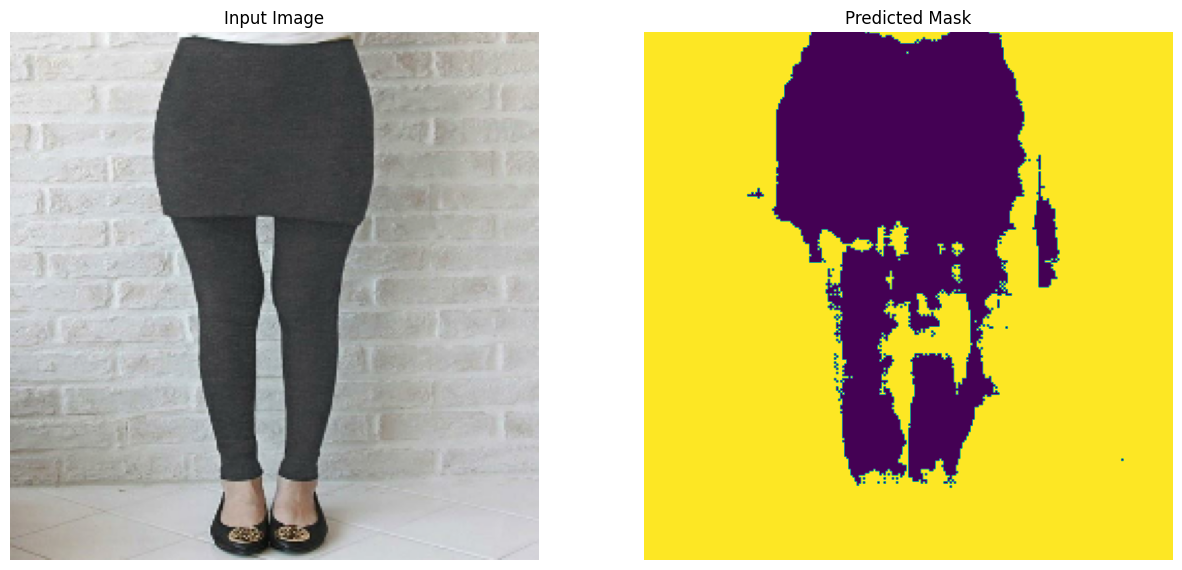

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


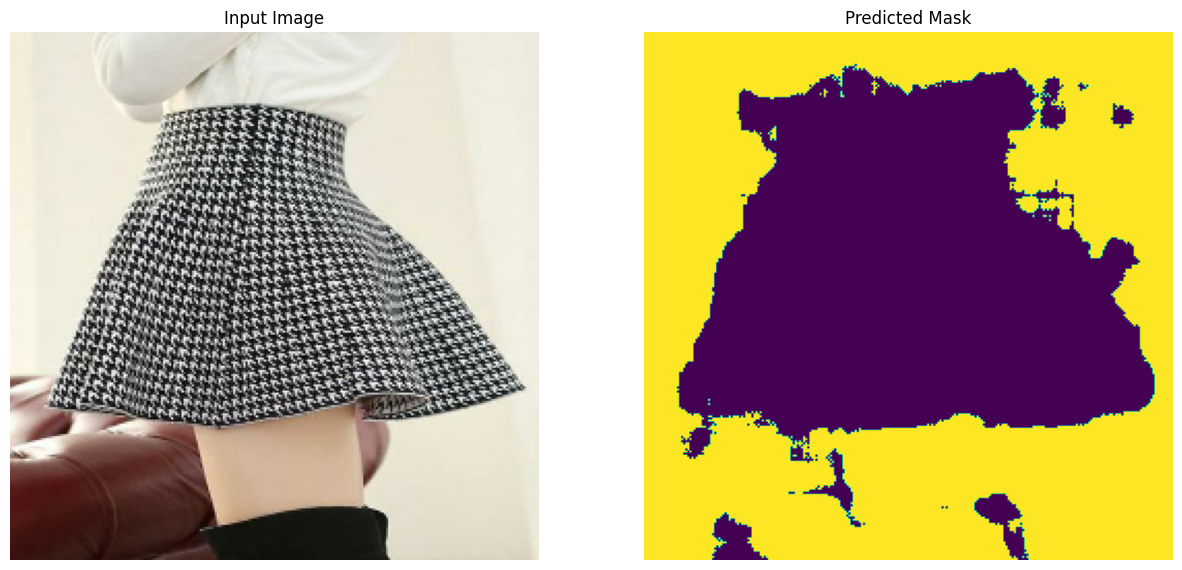

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


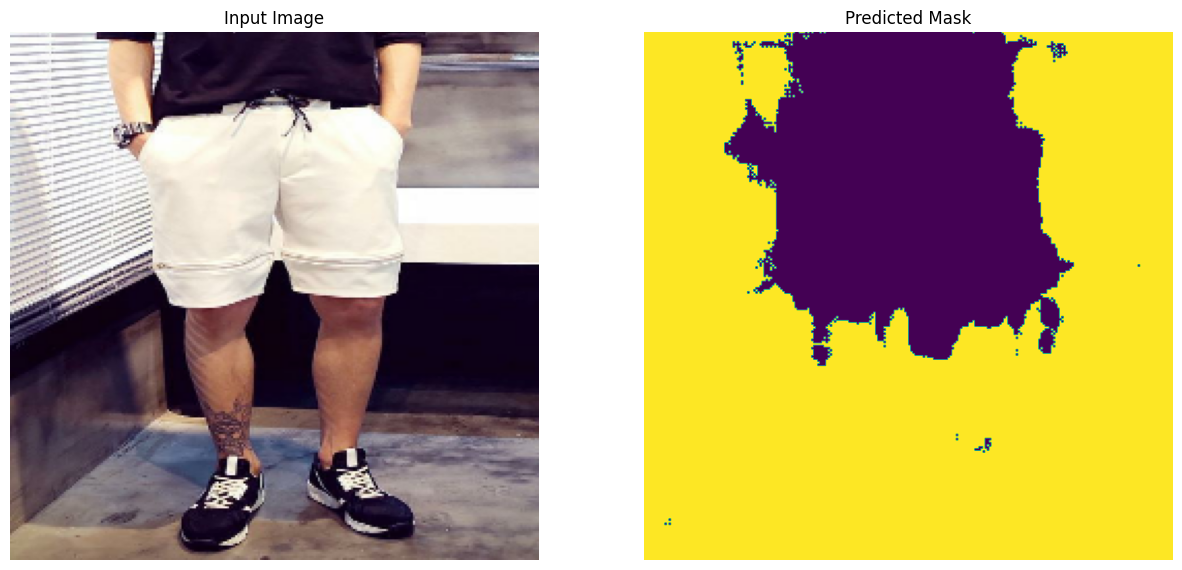

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


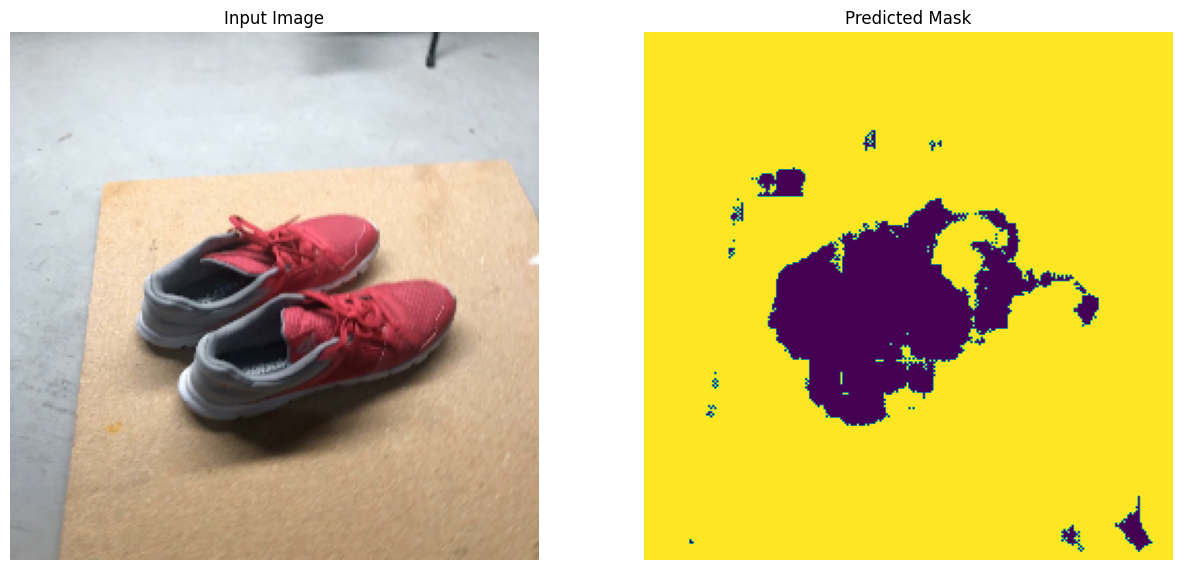

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


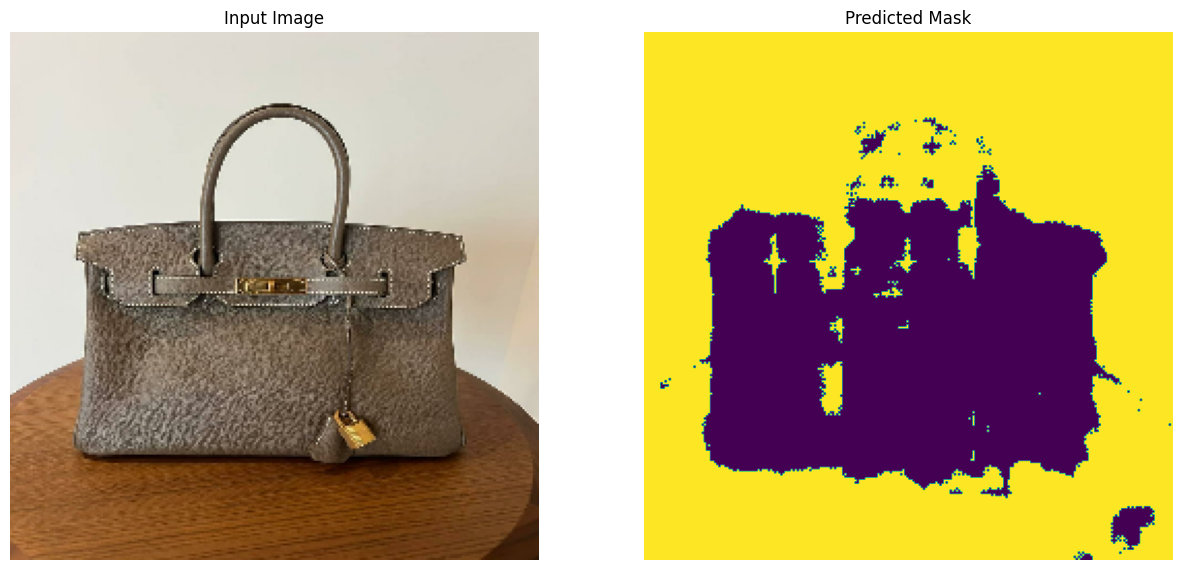

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


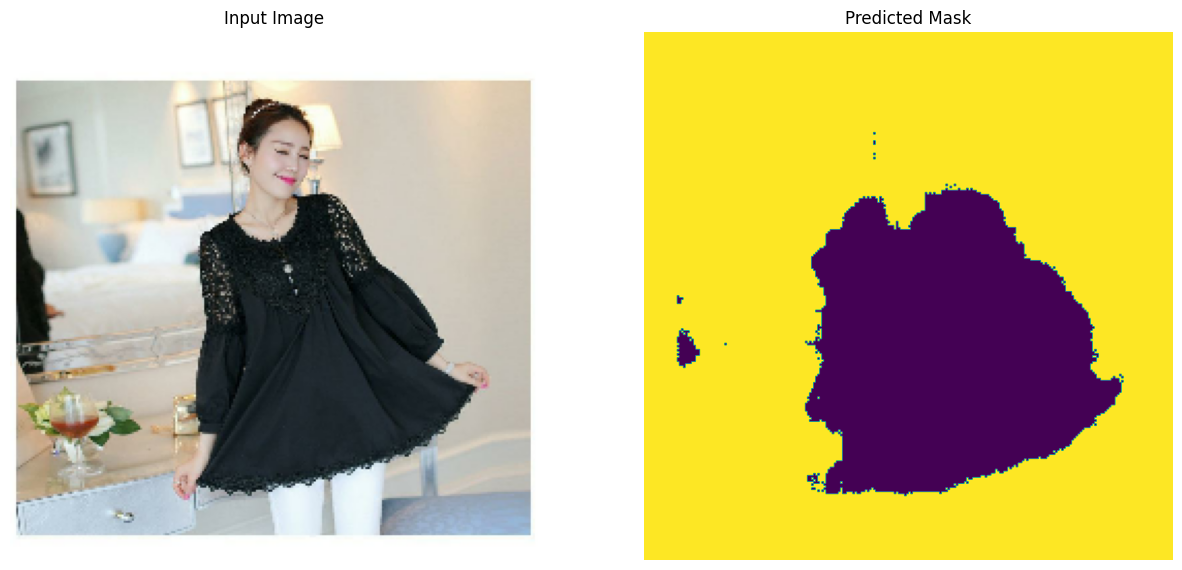

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


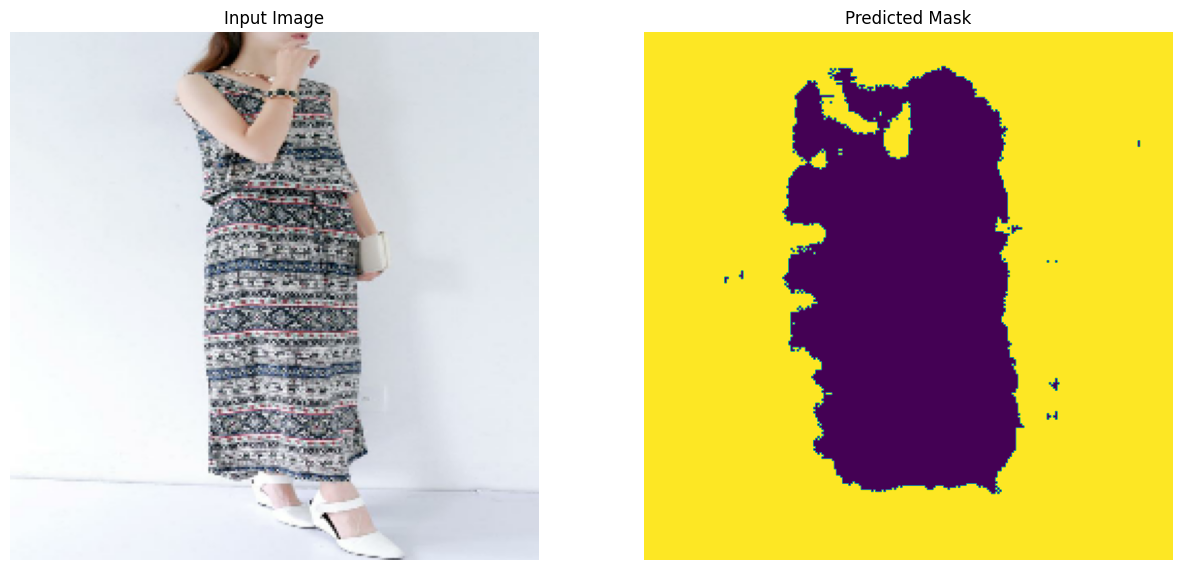

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


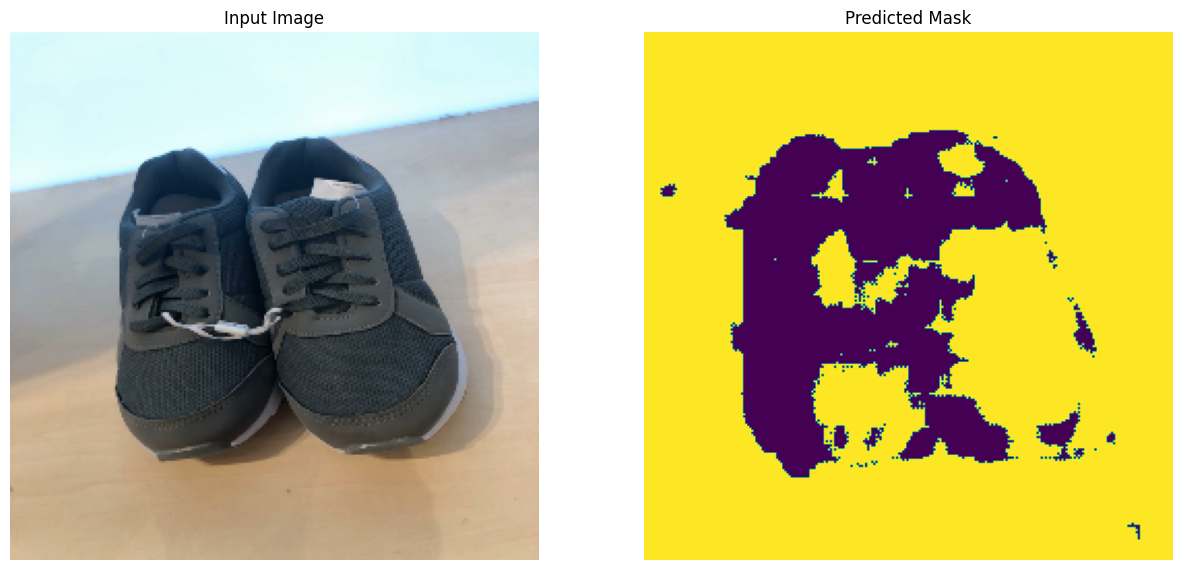

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


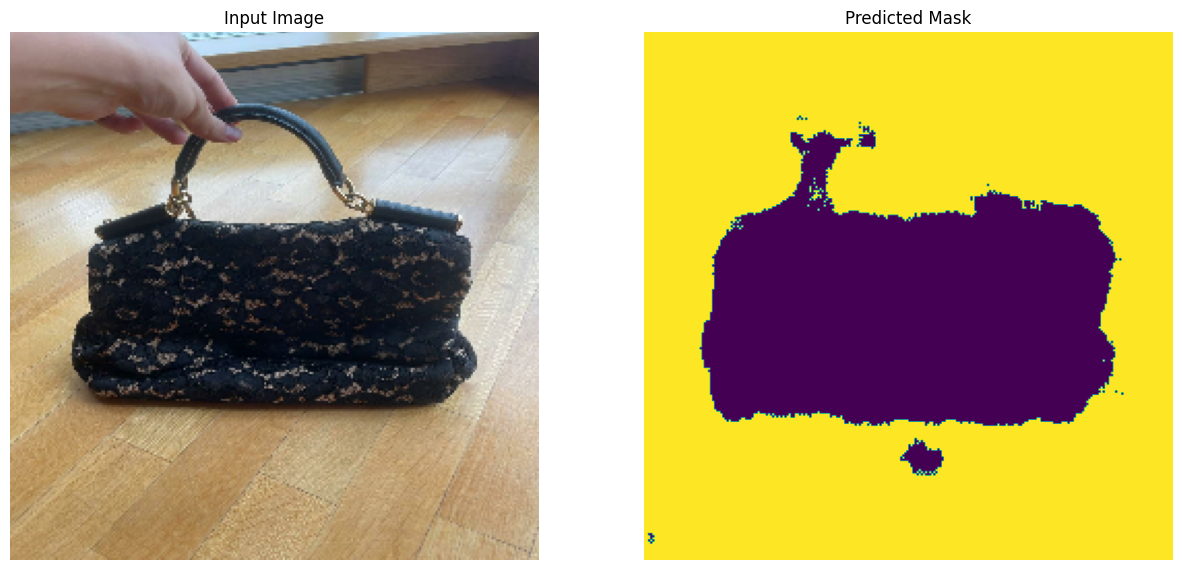

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


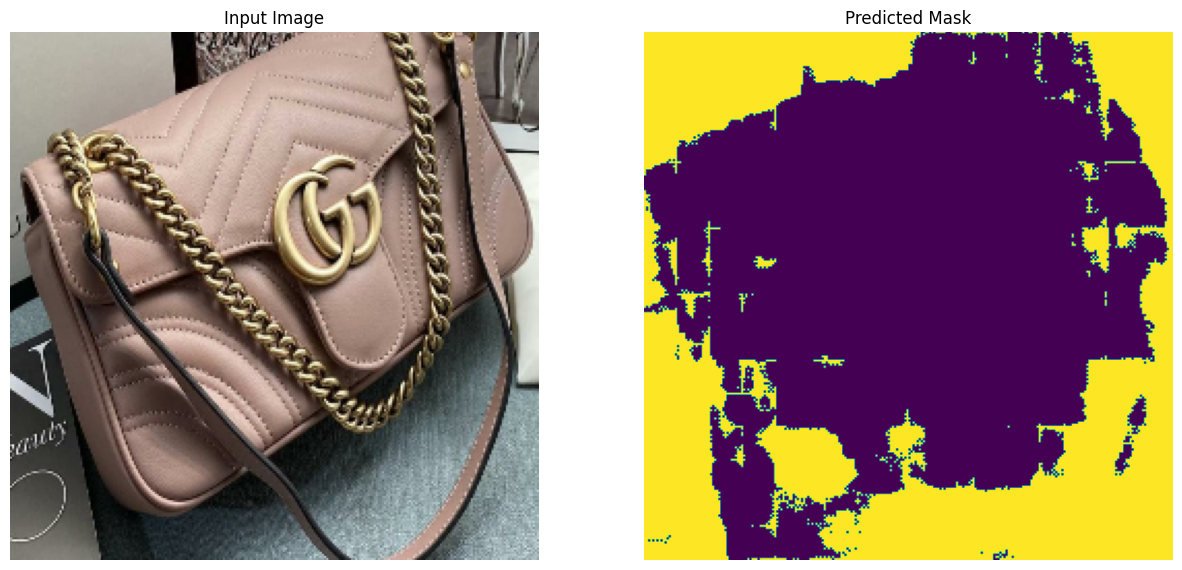

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


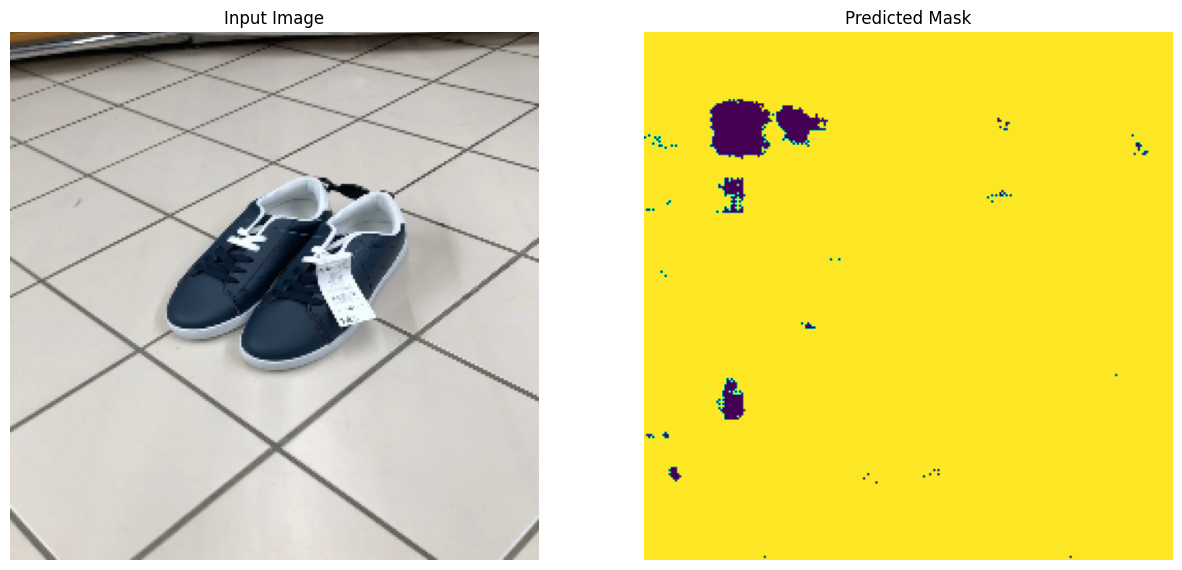

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


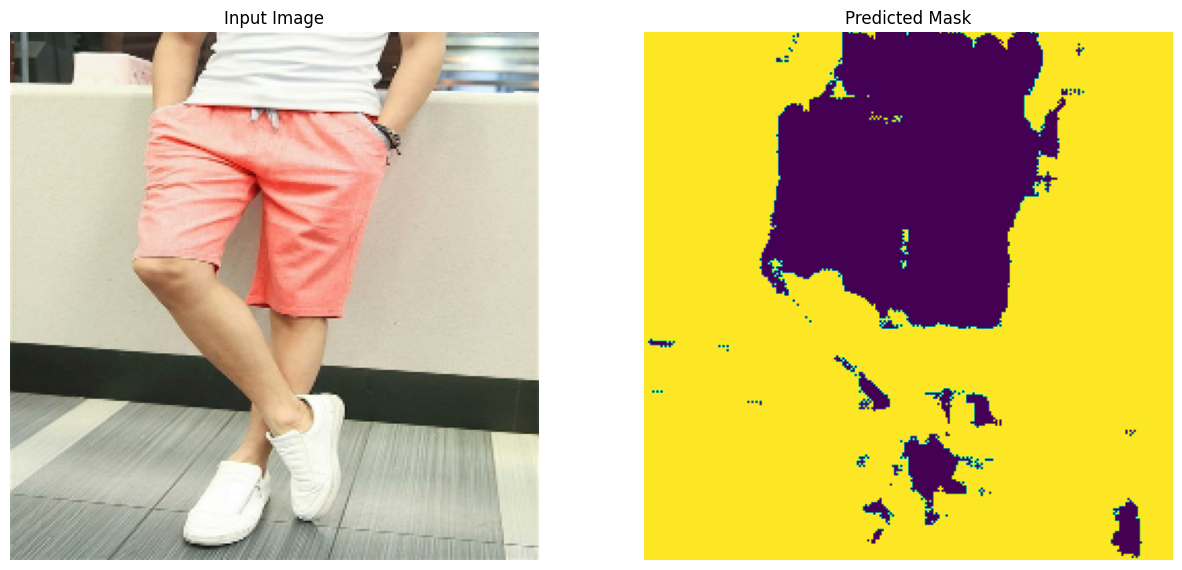

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


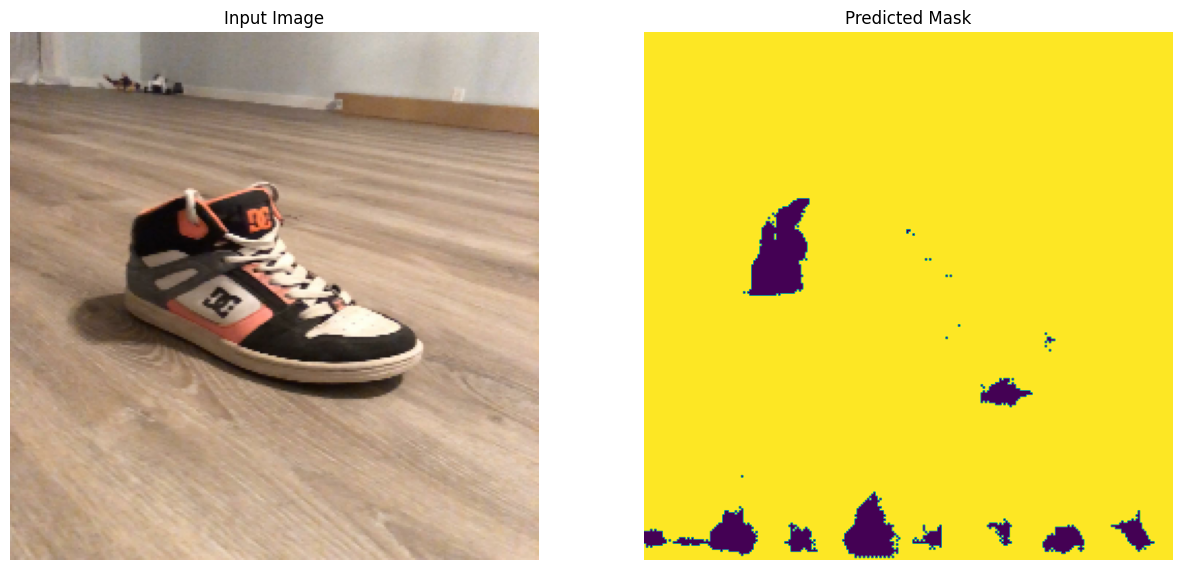

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


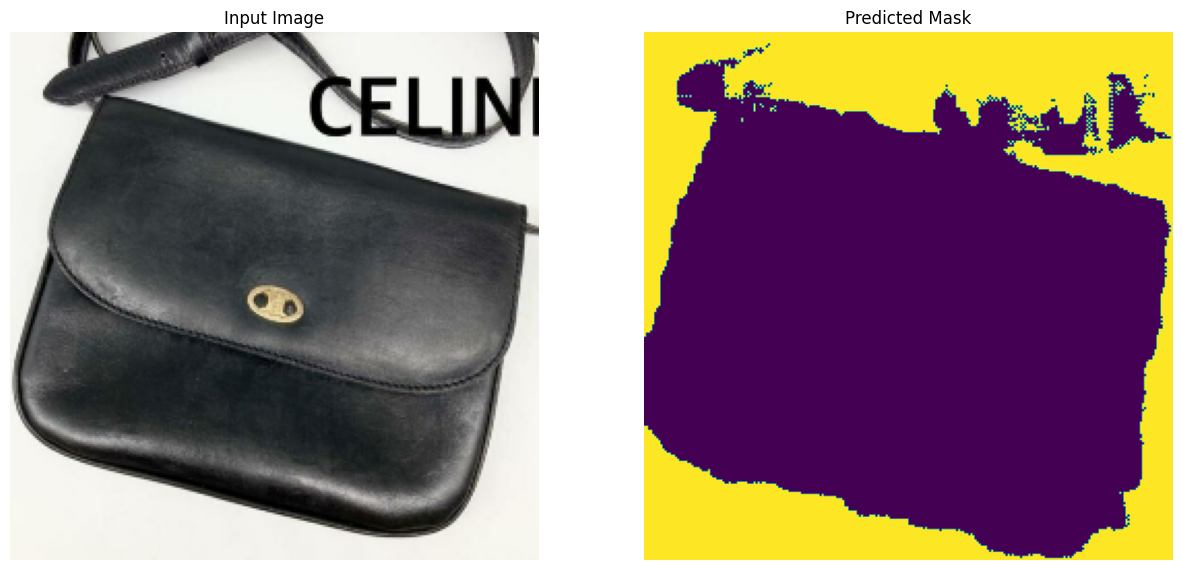

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


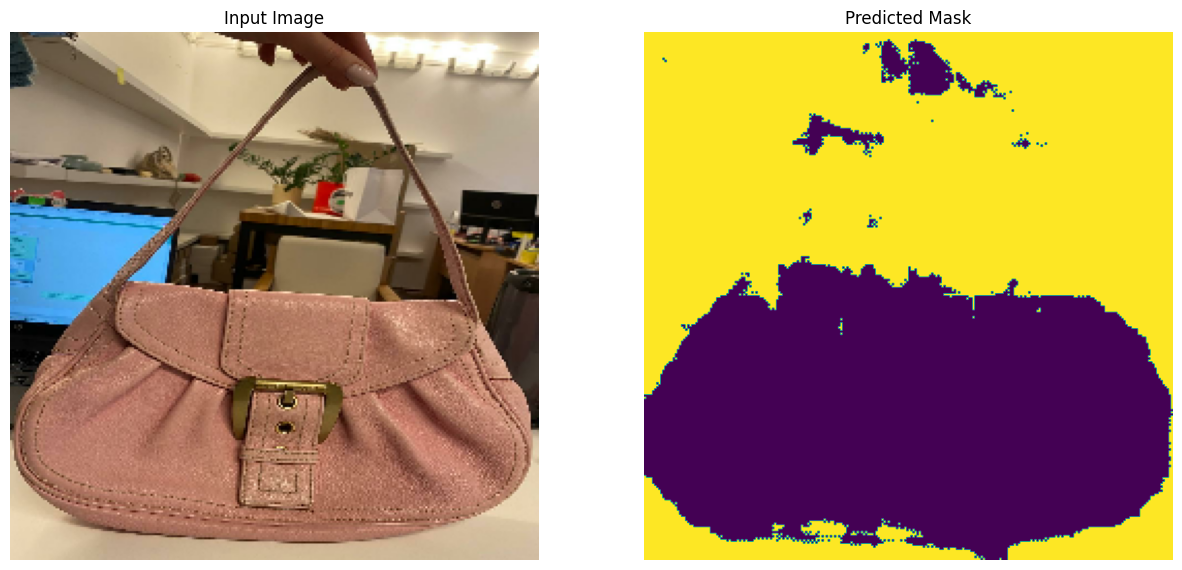

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


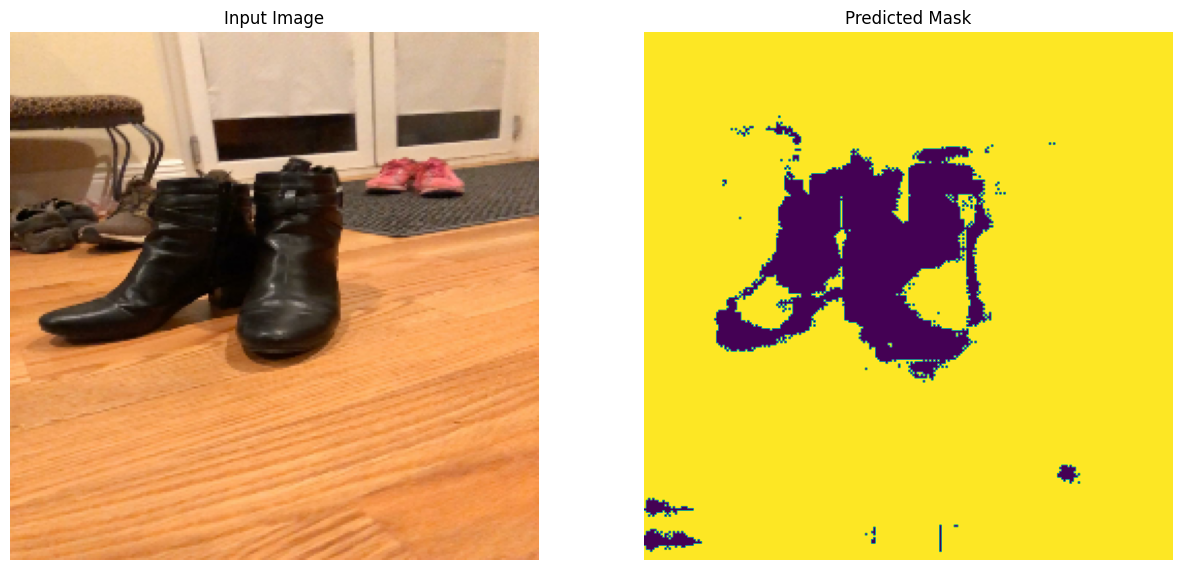

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


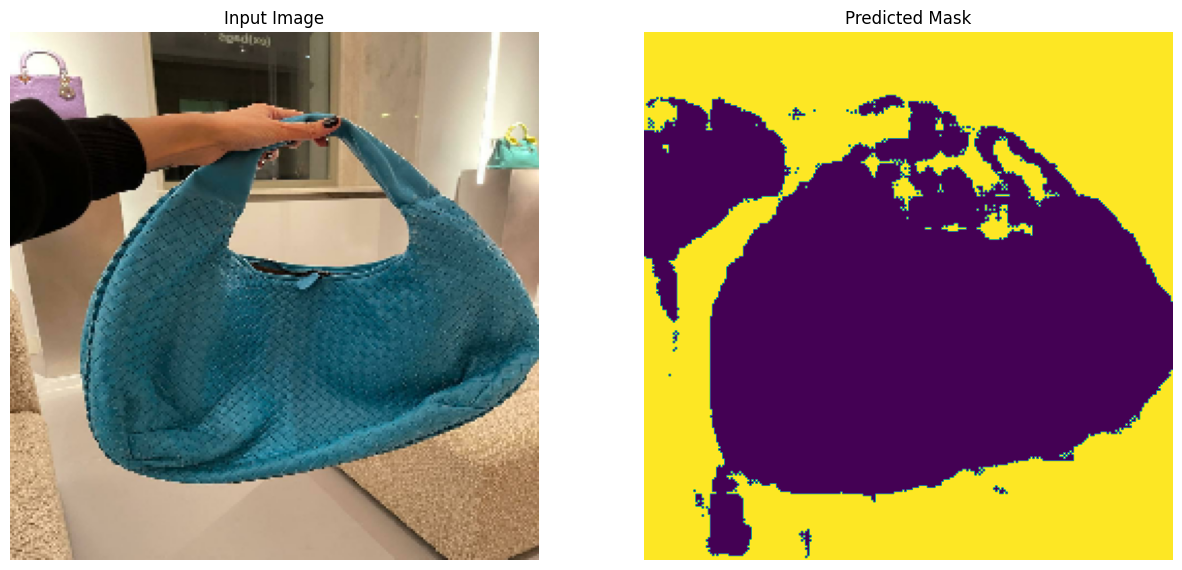

In [20]:

# define the directory where the test pictures are located
def find_links(directory):
  links = []
  for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    # Check if it's a file before adding to the list
    if os.path.isfile(filepath):
      links.append(filepath)

  return links


# Find all the links in the directory /content/test_pictures
links = find_links("/content/test_pictures")

for i in links:

  # Load and preprocess a sample image
  sample_image = preprocess_image(i)

  # Expand dimensions to match the model input shape
  input_image = tf.expand_dims(sample_image, axis=0)  # Shape: (1, 128, 128, 3)

  # Make a prediction
  predicted_mask = model.predict(input_image)

  # Post-process the predicted mask
  predicted_mask = create_mask(predicted_mask)

  # Display the input image and the predicted mask
  display([sample_image, predicted_mask])

### The previous data were generated from 10k training pictures with 20 epochs, I believe that using more pictures and increasing the number of epochs will enhance the results a lot.
### I recommend making the data set as balanced in the counts of each class as possible.